In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import wfdb
from wfdb.processing import normalize_bound

import confmain
from util_module import util_func
from util_module.ecg_signal import ECGSignal

In [2]:
record_number = "7"

curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, '../data/ludb')
record_dir = os.path.join(data_dir, record_number)

record = wfdb.rdrecord(record_dir)
dict_record = record.__dict__

# record_annot = wfdb.rdann(record_dir, 'hea')
# dict_record_annot = record_annot.__dict__

record.comments

['<age>: 50',
 '<sex>: M',
 '<diagnoses>:',
 'Rhythm: Sinus rhythm.',
 'Electric axis of the heart: horizontal.',
 'Atrial extrasystole: SA-nodal extrasystole.',
 'Atrial extrasystole, type: single PAC.',
 'Left atrial hypertrophy.',
 'Right atrial overload.',
 'Left ventricular hypertrophy.',
 'STEMI: anterior wall.',
 'STEMI: lateral wall.',
 'STEMI: septal.',
 'STEMI: apical.']

In [3]:
stemi_records = []
for i in range(1, 201):
    temp_record_dir = os.path.join(data_dir, str(i))
    temp_record = record = wfdb.rdrecord(temp_record_dir)
    
    for comment in temp_record.comments:
        if comment.startswith("STEMI:"):
            stemi_records.append(i)
            break

In [4]:
stemi_records

[7, 21, 24, 33, 55, 64, 69, 86]

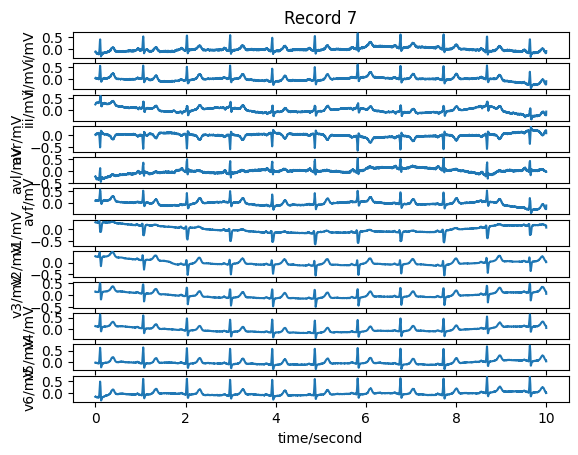

In [5]:
wfdb.plot_wfdb(record=record, title=f'Record {record_number}')

In [6]:
dict_record['p_signal'][:, 0]

array([-0.02910603, -0.02910603, -0.01871102, ..., -0.25779626,
       -0.18503119, -0.08939709])

In [7]:
dict_record['p_signal'][0]

array([-0.02910603,  0.42471591,  0.33511777, -0.27701375, -0.25271318,
        0.4015748 , -0.09929633, -0.17616912, -0.06547315, -0.05320946,
       -0.13901869, -0.17201835])

In [8]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [9]:
wfdb.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed QRS detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


## Denoise

In [10]:
#Frequency sample
fs = dict_record['fs']

signal = dict_record['p_signal'][:, 1]
WAVELET_FUNCTION = 'bior6.8'
DECOMPOSITION_LEVEL = 7

denoised_signal = util_func.denoise_dwt(signal, WAVELET_FUNCTION, DECOMPOSITION_LEVEL)

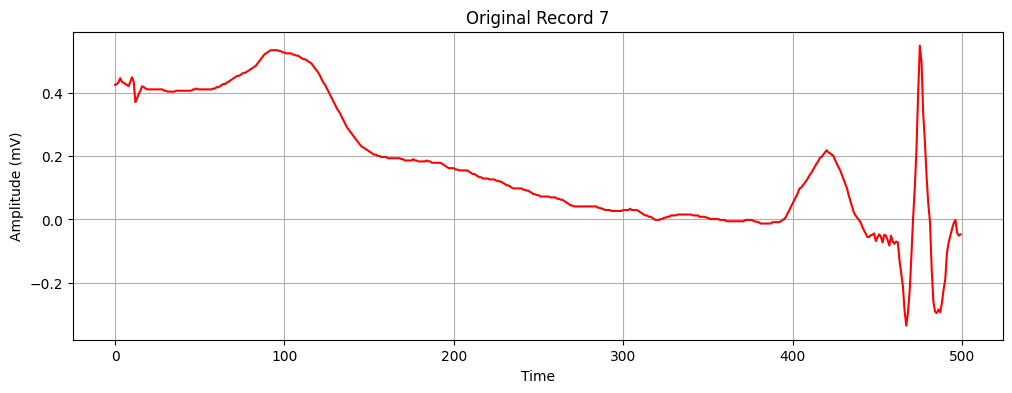

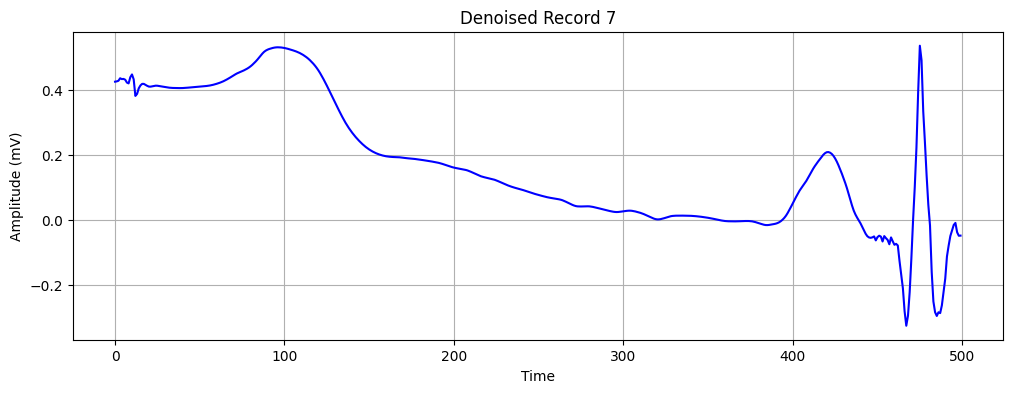

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(signal[:fs], color='red')
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Original Record {record_number}')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(denoised_signal[:fs], color='blue')
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Denoised Record {record_number}')
plt.grid(True)
plt.show()

## Normalize

Normalize them to [0, 1]

In [12]:
normalized_signal = normalize_bound(denoised_signal)

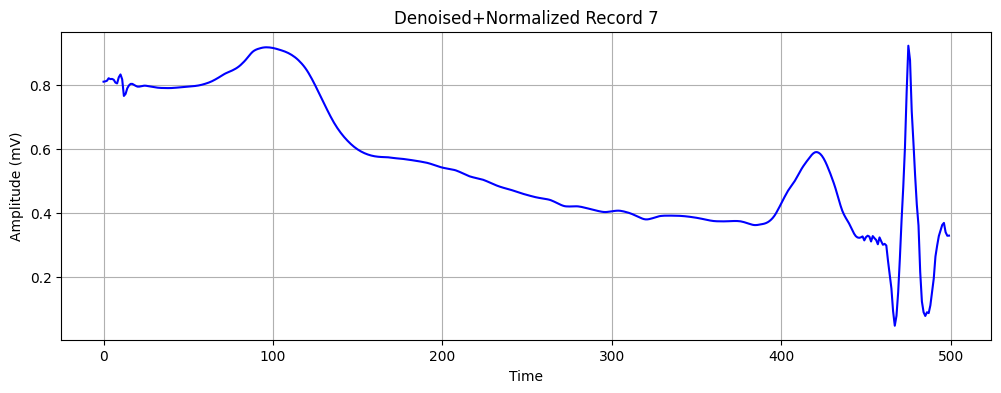

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(normalized_signal[:fs], label='Denoised+Normalized Signal', color='blue')
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Denoised+Normalized Record {record_number}')
plt.grid(True)
plt.show()

## Segmentation

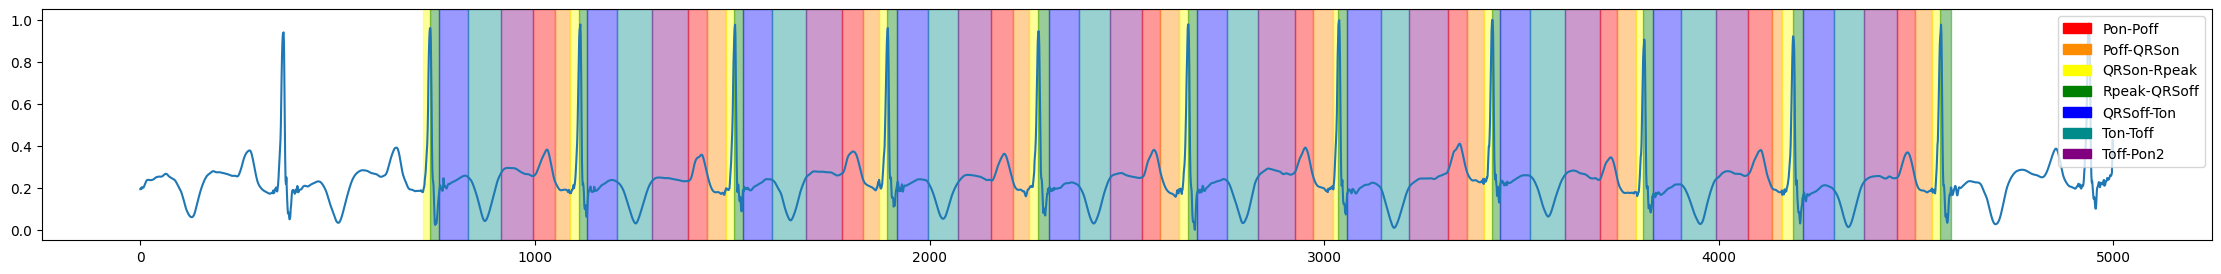

In [14]:
ecg = ECGSignal.load_ecg_signal(69, 'iii')

ecg.plot_segments()

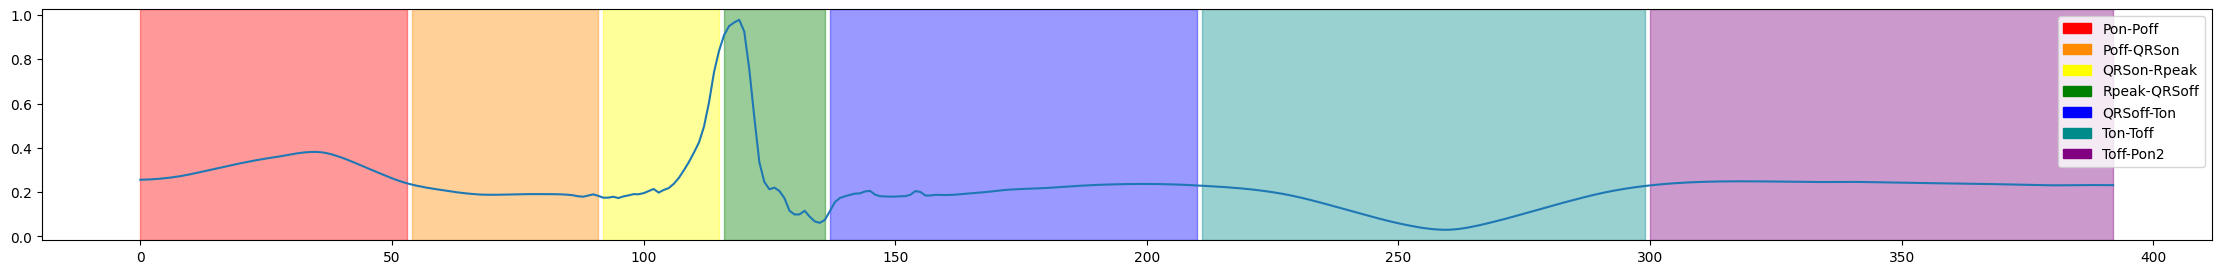

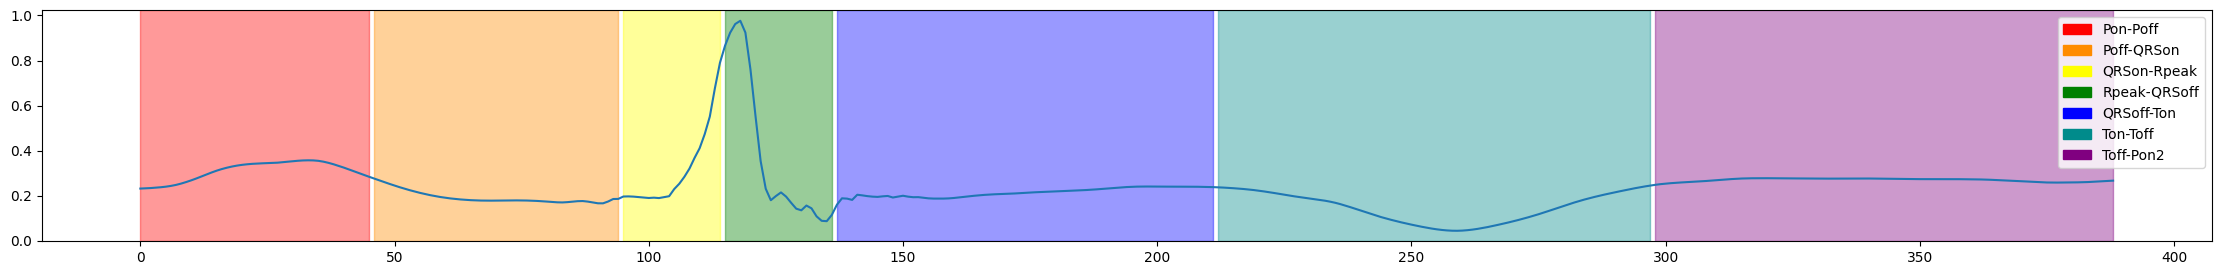

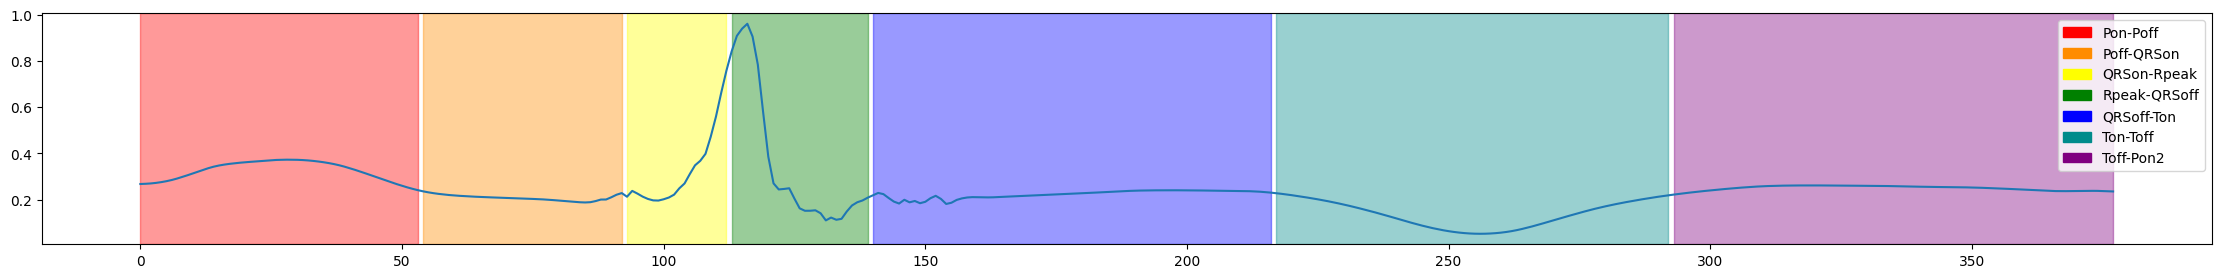

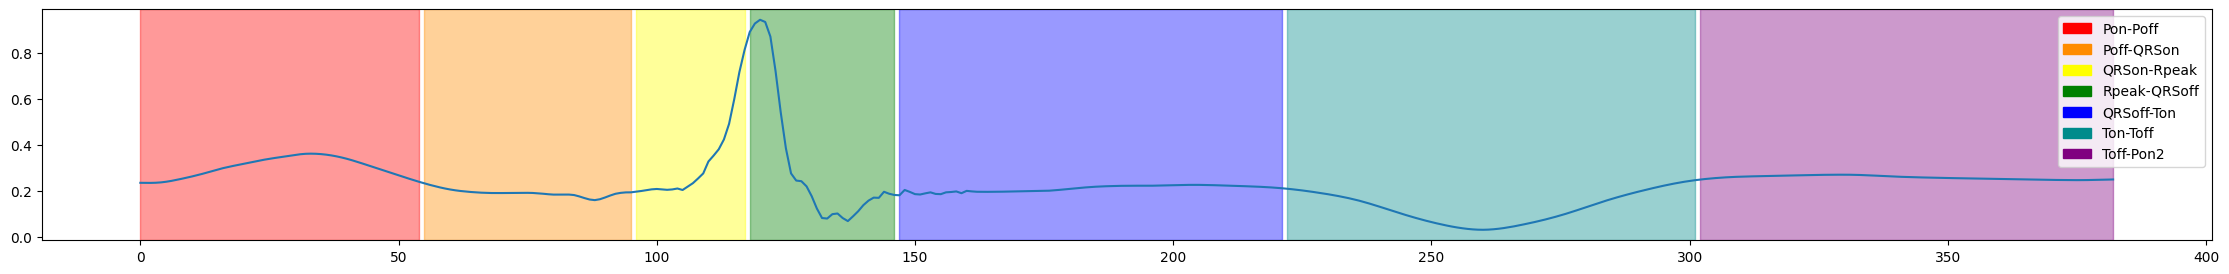

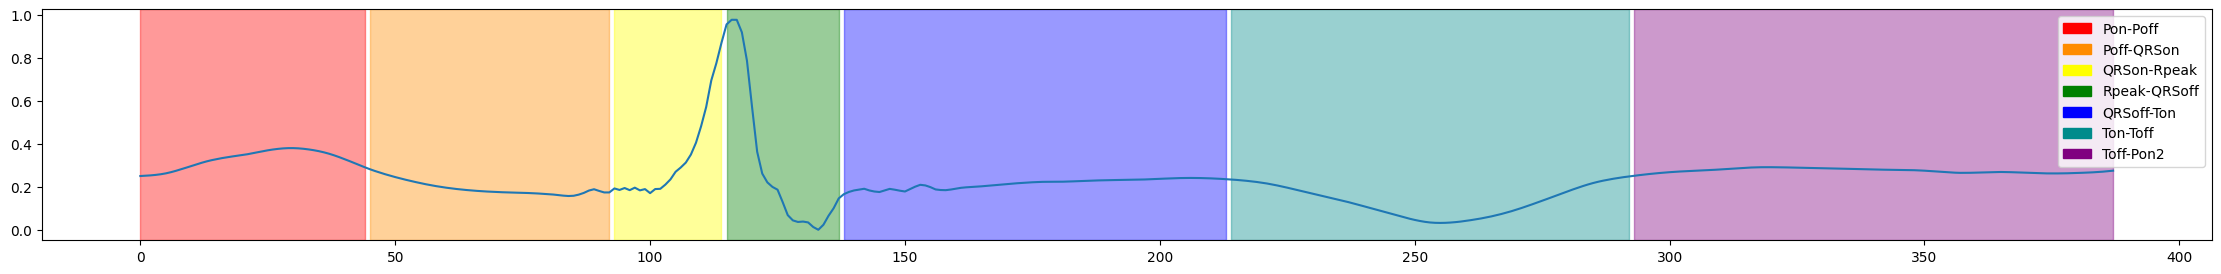

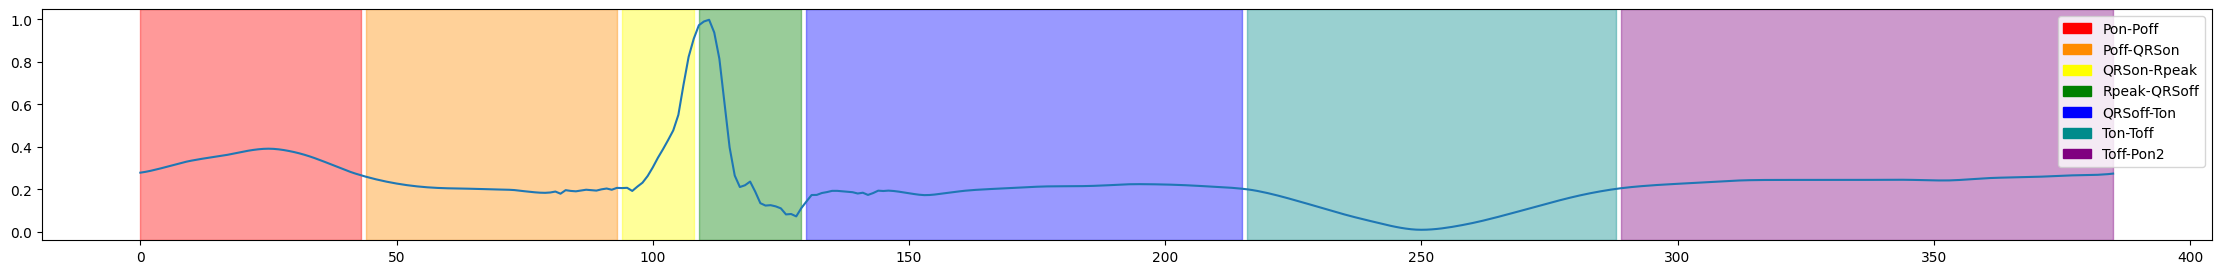

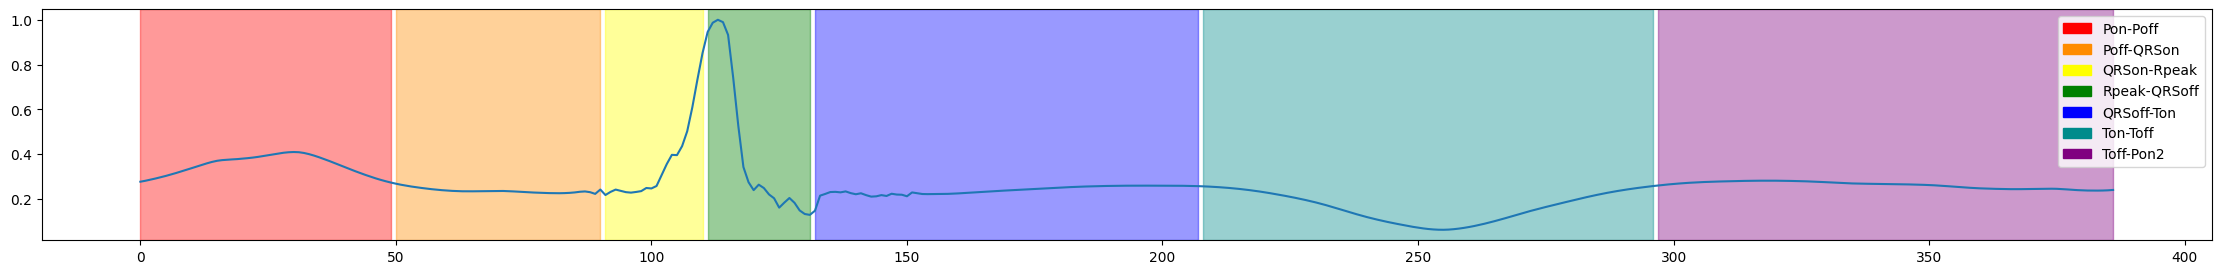

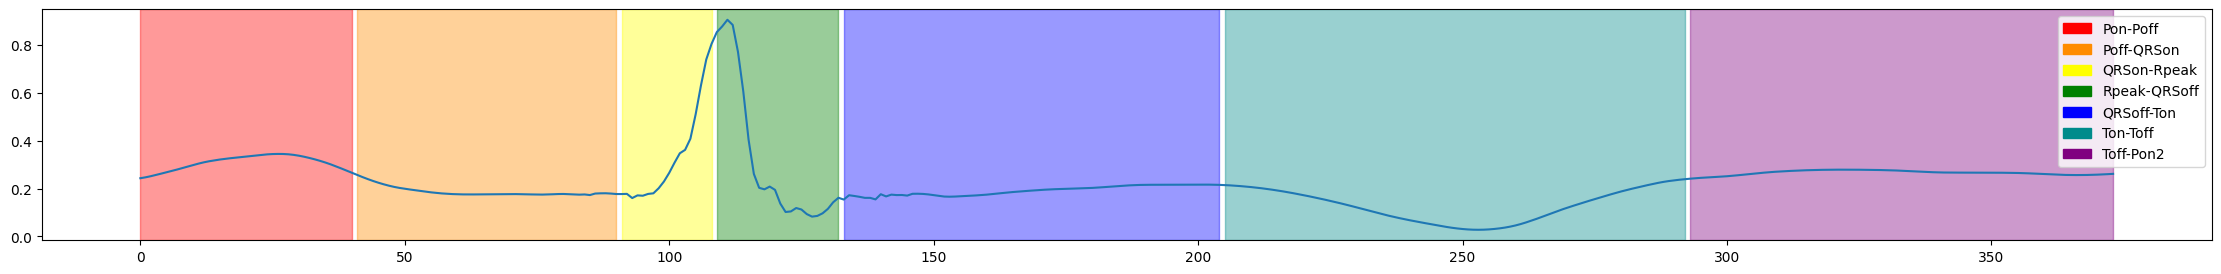

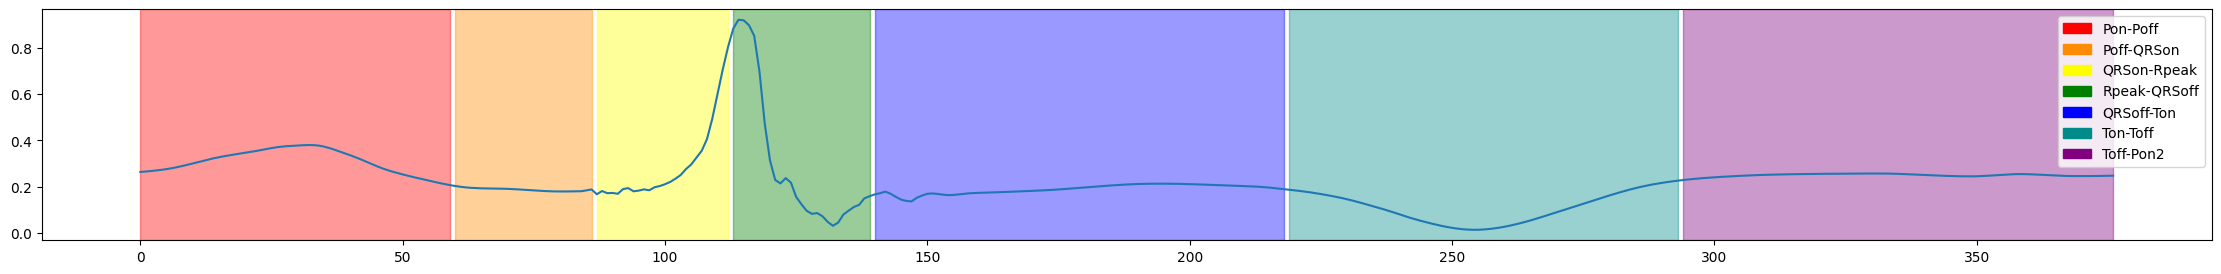

In [15]:
ecg_beats = ecg.cut_per_beat()

# plot record 125 lead ii normal beats
for signal, segment_map in ecg_beats:
    ECGSignal.plot_signal_segments(signal, segment_map)

## Extracting features and labels

In [16]:
# LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
# LEADS = ['i', 'ii', 'iii']
LEADS = ['avr']

final_data = ECGSignal.to_dict(LEADS)

In [17]:
len(final_data['signal'][0])

778

In [18]:
data_save_path = '../data/ludb_processed/ludb'

for lead in LEADS:
    data_save_path += f'_{lead}'

data_save_path += '.pickle'

In [19]:
# Uncomment and run to generate a new one
# util_func.make_dir('../data/ludb_processed/')
# util_func.save_file(data_save_path, final_data)